In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from fuzzywuzzy import fuzz
import re
import string

In [2]:
# Simple tokenization function (no NLTK dependency)
def tokenize(text):
    if not isinstance(text, str):
        return []
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Split by whitespace
    return [token.strip() for token in text.split() if token.strip()]

# Simple stemming function (for handling plurals without NLTK)
def simple_stem(word):
    """Very basic stemming for English words"""
    if not word or not isinstance(word, str):
        return word
        
    word = word.lower()
    
    # Common plural endings
    if len(word) > 3:
        if word.endswith('ies') and len(word) > 4:
            return word[:-3] + 'y'  # universities -> university
        elif word.endswith('es') and len(word) > 3:
            return word[:-2]  # classes -> class
        elif word.endswith('s') and not word.endswith('ss'):
            return word[:-1]  # students -> student
    
    return word

# Text preprocessing function (NLTK-free)
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
        
    # Tokenize
    tokens = tokenize(text)
    
    # Apply simple stemming
    stemmed_tokens = [simple_stem(token) for token in tokens]
    
    # Rejoin tokens
    return ' '.join(stemmed_tokens)

def extract_important_terms(text):
    """Extract important keywords from text that should be mandatory for matching."""
    if not isinstance(text, str):
        return []
    
    # List of common words that aren't important for matching
    common_words = {
        'where', 'what', 'when', 'how', 'who', 'why', 
        'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'a', 'an', 'the', 'and', 'but', 'or', 'for', 'nor', 'on', 'at', 'to', 'from', 'by',
        'about', 'like', 'through', 'over', 'before', 'between', 'after',
        'since', 'without', 'under', 'within', 'along', 'following',
        'can', 'could', 'should', 'would', 'may', 'might', 'must',
        'do', 'does', 'did', 'doing'
    }
    
    # Clean text
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    words = [w.strip() for w in text.split() if w.strip()]
    
    # Extract potentially important terms (not in common_words)
    important_terms = [w for w in words if w not in common_words]
    
    # Extract potential proper nouns (capitalized words in original text)
    original_words = text.split()
    proper_nouns = []
    for word in original_words:
        if word and word[0].isupper():
            proper_nouns.append(word.lower())
    
    # Prioritize proper nouns and multi-word terms
    priority_terms = list(set(proper_nouns))
    
    # Add any terms that might be locations or specific identifiers
    # (numbers, building names, etc.)
    specific_indicators = [
        w for w in important_terms 
        if any(char.isdigit() for char in w)  # Contains digits
        or len(w) > 3  # Longer terms are often more specific
    ]
    
    priority_terms.extend(specific_indicators)
    
    return list(set(priority_terms))

In [3]:
# Load and clean data
file_path = 'university_faq.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# Preprocess the dataset
df['Processed_Question'] = df['Question'].apply(preprocess_text)
df['Processed_Keyword'] = df['Keyword'].apply(preprocess_text)
df['Important_Terms'] = df['Question'].apply(extract_important_terms)

# Add entity extraction to keywords too
df['Keyword_Entities'] = df['Keyword'].apply(extract_important_terms)

# Build domain dictionary for spelling correction
domain_dictionary = set()
for text in df['Question'].tolist() + df['Keyword'].tolist():
    if isinstance(text, str):
        tokens = tokenize(text)
        domain_dictionary.update(tokens)

# Display first few rows of the processed dataset
df.head()

,Question,Keyword,Answer,Processed_Question,Processed_Keyword,Important_Terms,Keyword_Entities
0,What programs does the CSE department at MUJ o...,"programs, courses, undergraduate, postgraduate...",xxxyyy,what program do the cse department at muj offer,program cours undergraduate postgraduate phd cse,"[programs, department, offer]","[programs, postgraduate, undergraduate, courses]"
1,What are the eligibility criteria for admissio...,"eligibility, admission, criteria, entrance exa...",The answer to your question 'What are the elig...,what are the eligibility criteria for admissio...,eligibility admission criteria entrance exam j...,"[admission, criteria, eligibility]","[lateral, criteria, exam, eligibility, entry, ..."
2,What is the duration of the B.Tech CSE program...,"duration, course length, years, semesters, cur...",The answer to your question 'What is the durat...,what is the duration of the b tech cse program...,duration course length year semester curriculum,"[tech, program, duration]","[semesters, length, duration, years, course, c..."
3,Where is the CSE department located on the MUJ...,"department location, building, campus, block",The answer to your question 'Where is the CSE ...,where is the cse department located on the muj...,department location building campu block,"[campus, located, department]","[campus, department, block, building, location]"
4,Who is the head of the CSE department at MUJ?,"hod, faculty, administration, contact",The answer to your question 'Who is the head o...,who is the head of the cse department at muj,hod faculty administration contact,"[head, department]","[faculty, administration, contact]"


In [4]:
# Function to generate variations
def generate_variations(text):
    if not isinstance(text, str):
        return [text] if text else [""]
        
    variations = [text]
    
    # Simple plural/singular handling
    words = text.split()
    for i, word in enumerate(words):
        # Try both stemmed and original forms
        stemmed = simple_stem(word)
        if stemmed != word:
            new_words = words.copy()
            new_words[i] = stemmed
            variations.append(' '.join(new_words))
    
    # Add common misspellings for university terms
    common_misspellings = {
        'university': ['univercity', 'univarsity', 'uni'],
        'admission': ['admision', 'admisssion'],
        'scholarship': ['scolarship', 'scholarshipp'],
        'registration': ['registraton', 'registeration', 'signup'],
        'course': ['cours', 'coarse', 'class'],
        'professor': ['professer', 'proffesor', 'prof'],
        'semester': ['semister', 'semestre', 'term'],
        'tuition': ['tution', 'tuishon', 'fees'],
        'degree': ['degre', 'diploma', 'qualification'],
        'dormitory': ['dorm', 'housing', 'residence'],
        'major': ['specialization', 'concentration', 'field'],
        'credit': ['cred', 'unit', 'point'],
        'exam': ['examination', 'test', 'assessment'],
        'financial': ['fiscal', 'money', 'monetary'],
        'transfer': ['xfer', 'switch', 'change'],
        'deadline': ['due date', 'cutoff', 'timeframe'],
        'application': ['app', 'apply', 'submission'],
        'schedule': ['timetable', 'calendar', 'agenda']
    }
    
    for word, misspellings in common_misspellings.items():
        if word in text:
            for misspelling in misspellings:
                variations.append(text.replace(word, misspelling))
                
    return variations

# Uncommenting this section will expand your dataset with variations

# Option to expand dataset with variations
expanded_questions = []
expanded_keywords = []
expanded_answers = []
expanded_indices = []

for idx, row in df.iterrows():
    question_variations = generate_variations(row['Processed_Question'])
    keyword_variations = generate_variations(row['Processed_Keyword'])
    
    for q_var in question_variations:
        for k_var in keyword_variations:
            expanded_questions.append(q_var)
            expanded_keywords.append(k_var)
            expanded_answers.append(row['Answer'])
            expanded_indices.append(idx)  # Keep track of original index

expanded_df = pd.DataFrame({
    'Processed_Question': expanded_questions,
    'Processed_Keyword': expanded_keywords,
    'Answer': expanded_answers,
    'Original_Index': expanded_indices
})

# Use expanded dataset or original
# use_df = expanded_df
use_df = df  # Comment this out if using expanded dataset


In [5]:
# Initialize TF-IDF vectorizers with improved parameters
question_vectorizer = TfidfVectorizer(
    min_df=1, max_df=0.9,
    ngram_range=(1, 2),  # Include bigrams
    stop_words='english'
)

keyword_vectorizer = TfidfVectorizer(
    min_df=1, max_df=0.9,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit vectorizers
question_vectors = question_vectorizer.fit_transform(df['Processed_Question'])
keyword_vectors = keyword_vectorizer.fit_transform(df['Processed_Keyword'])

In [6]:
def correct_spelling(text):
    if not isinstance(text, str):
        return str(text) if text else ""
        
    try:
        corrected = str(TextBlob(text).correct())
        
        # Protect domain-specific terms from "correction"
        words = text.lower().split()
        corrected_words = corrected.lower().split()
        
        # Only replace words if length matches
        if len(words) == len(corrected_words):
            for i, (orig_word, corr_word) in enumerate(zip(words, corrected_words)):
                if orig_word in domain_dictionary and orig_word != corr_word:
                    corrected_words[i] = orig_word
            
            return ' '.join(corrected_words)
        return corrected
    except Exception as e:
        print(f"Spelling correction error: {e}")
        return text

# Matching function
def match_input(processed_input, original_input):
    try:
        # Extract important terms from user input
        user_important_terms = extract_important_terms(original_input)
        
        # Vector matching
        user_question_vector = question_vectorizer.transform([processed_input])
        question_similarities = cosine_similarity(user_question_vector, question_vectors)
        
        # Get top 5 matches for more detailed analysis
        top_n = 5
        top_question_indices = question_similarities[0].argsort()[-top_n:][::-1]
        top_question_scores = question_similarities[0][top_question_indices]
        
        # Do the same for keywords
        user_keyword_vector = keyword_vectorizer.transform([processed_input])
        keyword_similarities = cosine_similarity(user_keyword_vector, keyword_vectors)
        top_keyword_indices = keyword_similarities[0].argsort()[-top_n:][::-1]
        top_keyword_scores = keyword_similarities[0][top_keyword_indices]
        
        # Check for important term matches in top question matches
        question_match_idx = -1
        question_score = 0
        
        for i, idx in enumerate(top_question_indices):
            db_important_terms = df.iloc[idx]['Important_Terms']
            
            # Calculate what percentage of important terms from the DB question
            # are found in the user query
            matching_terms = [term for term in db_important_terms if term in processed_input]
            
            # Only consider it a match if at least one important term matches
            if len(matching_terms) > 0:
                # Adjust score based on important term matches
                term_match_ratio = len(matching_terms) / max(1, len(db_important_terms))
                adjusted_score = top_question_scores[i] * (0.5 + 0.5 * term_match_ratio)
                
                if adjusted_score > question_score:
                    question_score = adjusted_score
                    question_match_idx = idx
        
        # Check for important term matches in top keyword matches
        keyword_match_idx = -1
        keyword_score = 0
        
        for i, idx in enumerate(top_keyword_indices):
            keyword_entities = df.iloc[idx]['Keyword_Entities']
            
            # Check if any keyword entities match
            matching_entities = [entity for entity in keyword_entities if entity in processed_input]
            
            # Only consider it a match if at least one entity matches
            if len(matching_entities) > 0:
                # Adjust score based on entity matches
                entity_match_ratio = len(matching_entities) / max(1, len(keyword_entities))
                adjusted_score = top_keyword_scores[i] * (0.5 + 0.5 * entity_match_ratio)
                
                if adjusted_score > keyword_score:
                    keyword_score = adjusted_score
                    keyword_match_idx = idx
        
        # If we didn't find matches with important terms, fall back to the original method
        # but with reduced confidence
        if question_match_idx == -1:
            question_match_idx = top_question_indices[0]
            question_score = top_question_scores[0] * 0.7  # Reduce confidence
            
        if keyword_match_idx == -1:
            keyword_match_idx = top_keyword_indices[0]
            keyword_score = top_keyword_scores[0] * 0.7  # Reduce confidence
        
        # Determine best match
        if keyword_score > question_score:
            return {
                'answer': df.iloc[keyword_match_idx]['Answer'],
                'confidence': keyword_score,
                'match_type': 'keyword',
                'matched_question': df.iloc[keyword_match_idx]['Question']
            }
        else:
            return {
                'answer': df.iloc[question_match_idx]['Answer'],
                'confidence': question_score,
                'match_type': 'question', 
                'matched_question': df.iloc[question_match_idx]['Question']
            }
    except Exception as e:
        print(f"Vector matching error: {e}")
        return {'answer': "", 'confidence': 0.0, 'match_type': 'error', 'matched_question': ""}

def fuzzy_match(user_input):
    max_score = 0
    best_idx = -1
    
    # Extract important terms from user input
    user_important_terms = extract_important_terms(user_input)
    
    # Try both question and keyword fuzzy matching
    for idx, row in df.iterrows():
        try:
            question = row.get('Question', '')
            keyword = row.get('Keyword', '')
            
            if isinstance(question, str) and isinstance(keyword, str):
                # Use token_sort_ratio for better handling of word order differences
                q_score = fuzz.token_sort_ratio(user_input.lower(), question.lower())
                k_score = fuzz.token_sort_ratio(user_input.lower(), keyword.lower())
                
                # Also try partial ratio for substring matching
                q_partial = fuzz.partial_ratio(user_input.lower(), question.lower())
                k_partial = fuzz.partial_ratio(user_input.lower(), keyword.lower())
                
                # Take the best score
                max_row_score = max(q_score, k_score, q_partial, k_partial) / 100
                
                # Check if important terms match
                important_terms = row.get('Important_Terms', [])
                if important_terms:
                    matching_terms = [term for term in important_terms if term in user_input.lower()]
                    # If no important terms match, reduce the score
                    if len(matching_terms) == 0 and len(important_terms) > 0:
                        max_row_score *= 0.7
                
                if max_row_score > max_score:
                    max_score = max_row_score
                    best_idx = idx
        except Exception as e:
            print(f"Fuzzy matching error on row {idx}: {e}")
    
    if best_idx >= 0:
        return {
            'answer': df.iloc[best_idx]['Answer'],
            'confidence': max_score,
            'match_type': 'fuzzy',
            'matched_question': df.iloc[best_idx]['Question']
        }
    return {'answer': "", 'confidence': 0.0, 'match_type': 'fuzzy_failed', 'matched_question': ""}

In [7]:
# Enhanced response function
def get_response(user_input, confidence_threshold=0.5):
    if not isinstance(user_input, str) or not user_input.strip():
        return "I need a question to help you.", 0.0
    
    # Step 1: Preprocess input
    processed_input = preprocess_text(user_input)
    
    # Step 2: Try with original preprocessed input
    result = match_input(processed_input, user_input)
    if result['confidence'] >= confidence_threshold:
        return result['answer'], result['confidence'], result['matched_question']
    
    # Step 3: Try spelling correction if confidence is low
    corrected_input = correct_spelling(user_input)
    if corrected_input.lower() != user_input.lower():
        processed_corrected = preprocess_text(corrected_input)
        corrected_result = match_input(processed_corrected, corrected_input)
        if corrected_result['confidence'] > result['confidence']:
            return corrected_result['answer'], corrected_result['confidence'], corrected_result['matched_question'], corrected_input
    
    # Step 4: Try fuzzy matching as another fallback
    fuzzy_result = fuzzy_match(user_input)
    if fuzzy_result['confidence'] > result['confidence']:
        return fuzzy_result['answer'], fuzzy_result['confidence'], fuzzy_result.get('matched_question', '')
    
    # Return best result found, even if confidence is low
    if result['confidence'] > 0.15:  # Minimum threshold
        return result['answer'], result['confidence'], result['matched_question']
    
    return "I'm not sure I understand. Could you rephrase your question?", 0.0, ""

# Example usage
def chatbot_response(user_input):
    try:
        result = get_response(user_input)
        
        # Unpack response based on length
        if len(result) == 4:  # Corrected spelling case
            answer, confidence, matched_question, corrected = result
            response_text = ""
            
            if confidence < 0.4:
                response_text = f"Did you mean: '{corrected}'?\n\nI need to research this further. Would you like me to send your question to our faculty? Please provide your email address."
            elif confidence > 0.6:
                response_text = f"Did you mean: '{corrected}'?\n\n{answer}"
            else:
                response_text = f"Did you mean: '{corrected}'?\n\nI think you're asking about: '{matched_question}'\n\n{answer}"
            
            return response_text
            
        elif len(result) == 3:  # Normal case with matched question
            answer, confidence, matched_question = result
            
            if confidence < 0.4:
                return "I need to research this further. Would you like me to send your question to our faculty? Please provide your email address."
            elif confidence > 0.6:
                return answer
            else:
                return f"I think you're asking about: '{matched_question}'\n\n{answer}"
        else:
            answer, confidence = result
            if confidence < 0.4:
                return "I need to research this further. Would you like me to send your question to our faculty? Please provide your email address."
            elif confidence > 0.6:
                return answer
            else:
                return f"I'm not entirely sure, but this might help: {answer}"
                
    except Exception as e:
        return f"Sorry, I encountered an error processing your question. Please try again with different wording."

In [ ]:
# Main chatbot loop
print("University FAQ Chatbot (type 'exit' to quit)")
while True:
    user_input = input("Ask me something: ").strip()
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break
    response = chatbot_response(user_input)
    print(f"Chatbot: {response}\n")

University FAQ Chatbot (type 'exit' to quit)


Ask me something:  where is cheffie


Chatbot: in SAC



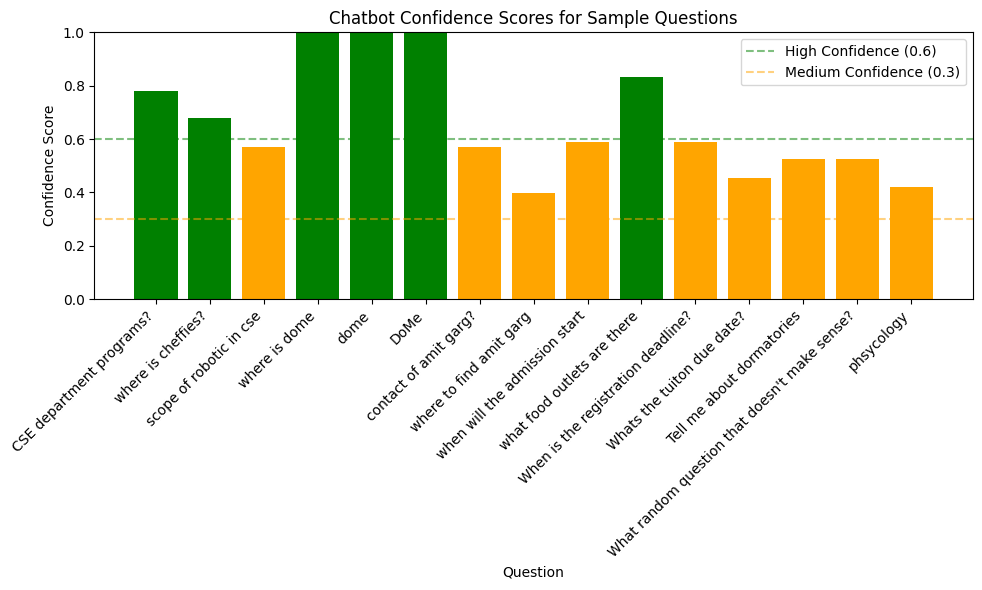

,question,confidence,response
0,CSE department programs?,0.780000,The answer to your question 'Who is the head o...
1,where is cheffies?,0.679000,in SAC
2,scope of robotic in cse,0.570000,I think you're asking about: 'How does MUJ sup...
3,where is dome,1.000000,front of ab2
4,dome,1.000000,front of ab2
5,DoMe,1.000000,front of ab2
6,contact of amit garg?,0.570000,I think you're asking about: 'How can I contac...
7,where to find amit garg,0.399000,I need to research this further. Would you lik...
8,when will the admission start,0.590000,I think you're asking about: 'What are the eli...
9,what food outlets are there,0.833333,"old mess, sac, ab2"


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def test_and_visualize_questions(questions):
    results = []
    for q in questions:
        result = get_response(q)
        conf = result[1] if len(result) >= 2 else 0
        results.append({
            'question': q,
            'confidence': conf,
            'response': chatbot_response(q)
        })
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    confidences = [r['confidence'] for r in results]
    questions = [r['question'] for r in results]
    
    bar_colors = ['green' if c > 0.6 else 'orange' if c > 0.3 else 'red' for c in confidences]
    
    bars = ax.bar(range(len(questions)), confidences, color=bar_colors)
    
    ax.set_xlabel('Question')
    ax.set_ylabel('Confidence Score')
    ax.set_title('Chatbot Confidence Scores for Sample Questions')
    ax.set_xticks(range(len(questions)))
    ax.set_xticklabels(questions, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    
    # Add threshold lines
    ax.axhline(y=0.6, color='green', linestyle='--', alpha=0.5, label='High Confidence (0.6)')
    ax.axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Medium Confidence (0.3)')
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Display detailed results in a table
    return pd.DataFrame(results)

# Test with sample questions
sample_questions = [
    "CSE department programs?",
    "where is cheffies?",
    # "What kind of support does MUJ provide for CSE students interested in robotics research?",
    "scope of robotic in cse",
    "where is dome",
    "dome",
    "DoMe",
    "contact of amit garg?",
    "where to find amit garg",
    "when will the admission start",
    "what food outlets are there",
    "When is the registration deadline?",
    "Whats the tuiton due date?",  # Intentional typo
    "Tell me about dormatories",  # Intentional typo
    "What random question that doesn't make sense?",
    "phsycology"
]

results_df = test_and_visualize_questions(sample_questions)
results_df